In [1]:
! pip install xgboost

  Using cached xgboost-3.2.0-py3-none-win_amd64.whl.metadata (2.1 kB)
Using cached xgboost-3.2.0-py3-none-win_amd64.whl (101.7 MB)


In [2]:
! pip install lightgbm

  Using cached lightgbm-4.6.0-py3-none-win_amd64.whl.metadata (17 kB)
Using cached lightgbm-4.6.0-py3-none-win_amd64.whl (1.5 MB)


In [3]:
! pip install catboost

  Using cached graphviz-0.21-py3-none-any.whl.metadata (12 kB)
   ---------------------------------------- 0.0/102.4 MB ? eta -:--:--
   ---------------------------------------- 0.0/102.4 MB ? eta -:--:--
   ---------------------------------------- 0.5/102.4 MB 2.0 MB/s eta 0:00:51
    --------------------------------------- 1.8/102.4 MB 5.4 MB/s eta 0:00:19
   - -------------------------------------- 3.4/102.4 MB 6.2 MB/s eta 0:00:16
   - -------------------------------------- 4.7/102.4 MB 6.0 MB/s eta 0:00:17
   -- ------------------------------------- 6.3/102.4 MB 6.2 MB/s eta 0:00:16
   -- ------------------------------------- 6.8/102.4 MB 5.7 MB/s eta 0:00:17
   --- ------------------------------------ 8.9/102.4 MB 6.3 MB/s eta 0:00:15
   ---- ----------------------------------- 10.7/102.4 MB 6.6 MB/s eta 0:00:14
   ----- ---------------------------------- 12.8/102.4 MB 7.0 MB/s eta 0:00:13
   ----- ---------------------------------- 13.6/102.4 MB 7.3 MB/s eta 0:00:13
   ----- ---

In [4]:

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline


# classification
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier


from sklearn.metrics import classification_report, f1_score, accuracy_score, recall_score, precision_score

In [5]:
df = pd.read_csv("train.csv")
df.head()

,id,Age,Sex,Chest pain type,BP,Cholesterol,FBS over 120,EKG results,Max HR,Exercise angina,ST depression,Slope of ST,Number of vessels fluro,Thallium,Heart Disease
0,0,58,1,4,152,239,0,0,158,1,3.6,2,2,7,Presence
1,1,52,1,1,125,325,0,2,171,0,0.0,1,0,3,Absence
2,2,56,0,2,160,188,0,2,151,0,0.0,1,0,3,Absence
3,3,44,0,3,134,229,0,2,150,0,1.0,2,0,3,Absence
4,4,58,1,4,140,234,0,2,125,1,3.8,2,3,3,Presence


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 630000 entries, 0 to 629999
Data columns (total 15 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   id                       630000 non-null  int64  
 1   Age                      630000 non-null  int64  
 2   Sex                      630000 non-null  int64  
 3   Chest pain type          630000 non-null  int64  
 4   BP                       630000 non-null  int64  
 5   Cholesterol              630000 non-null  int64  
 6   FBS over 120             630000 non-null  int64  
 7   EKG results              630000 non-null  int64  
 8   Max HR                   630000 non-null  int64  
 9   Exercise angina          630000 non-null  int64  
 10  ST depression            630000 non-null  float64
 11  Slope of ST              630000 non-null  int64  
 12  Number of vessels fluro  630000 non-null  int64  
 13  Thallium                 630000 non-null  int64  
 14  Hear

In [28]:
def preprocess(df, target_col):
    df = df.copy()
    df = df.drop_duplicates()
    df = df.dropna(subset=[target_col])

    X = df.drop(columns=[target_col])
    y = df[target_col]

    # Drop id if present
    if 'id' in X.columns:
        X = X.drop(columns=['id'])

    num_cols = X.select_dtypes(include=['int64', 'float64']).columns
    cat_cols = X.select_dtypes(include=['object', 'category']).columns

    preprocessor = ColumnTransformer(

    transformers=[

        ('num', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy="mean")),
            ('scaler', StandardScaler())
        ]), num_cols),
        
        ('cat', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('encoder', OneHotEncoder(handle_unknown='ignore'))
        ]), cat_cols)
    ]
)


    return X, y, preprocessor

In [29]:
X, y , preprocessor = preprocess(df, target_col='Heart Disease')

In [32]:
le = LabelEncoder()
y = le.fit_transform(y)

<Axes: ylabel='count'>

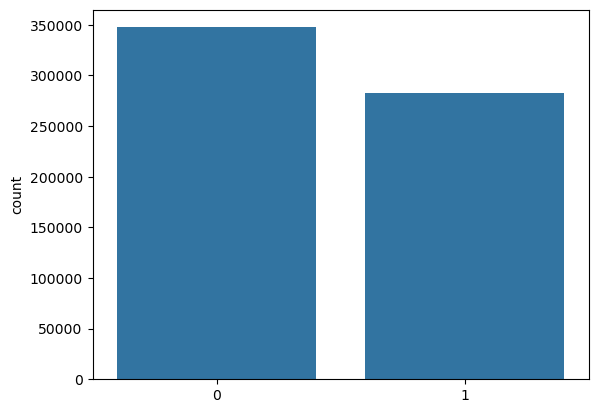

In [33]:
#target column distribution 
sns.countplot(x=y)

## Modelling 

In [11]:
def modelling_without_tuning_pipeline(X, y, preprocessor):

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    res = {}
    models = [
            RandomForestClassifier(),
            AdaBoostClassifier(),
            GradientBoostingClassifier(),
            XGBClassifier(),
            LGBMClassifier(),
        ]

    for model in models:
            pipe = Pipeline([
                ("preprocessor", preprocessor),
                ("model", model)
            ])

            pipe.fit(X_train, y_train)
            y_pred = pipe.predict(X_test)

            model_name = type(model).__name__

            res[model_name] = {
                "accuracy": accuracy_score(y_test, y_pred),
                "f1_score": f1_score(y_test, y_pred, average="macro"),
                "recall": recall_score(y_test, y_pred, average="macro"),
                "precision": precision_score(y_test, y_pred, average="macro")
            }

    return res

In [12]:
result = modelling_without_tuning_pipeline(X, y, preprocessor)

[LightGBM] [Info] Number of positive: 226018, number of negative: 277982
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.033487 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 422
[LightGBM] [Info] Number of data points in the train set: 504000, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.448448 -> initscore=-0.206942
[LightGBM] [Info] Start training from score -0.206942


C:\Users\smitsatani\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


In [13]:
result

{'RandomForestClassifier': {'accuracy': 0.8800555555555556,
  'f1_score': 0.8785815117901588,
  'recall': 0.8781080223098036,
  'precision': 0.8791202225936414},
 'AdaBoostClassifier': {'accuracy': 0.8847301587301587,
  'f1_score': 0.8833343483876923,
  'recall': 0.8829183626437469,
  'precision': 0.8837995203634068},
 'GradientBoostingClassifier': {'accuracy': 0.8860793650793651,
  'f1_score': 0.8846442120963783,
  'recall': 0.8840549886903479,
  'precision': 0.8853323260326695},
 'XGBClassifier': {'accuracy': 0.8869920634920635,
  'f1_score': 0.8855817109048743,
  'recall': 0.8850320427200076,
  'precision': 0.8862169390872938},
 'LGBMClassifier': {'accuracy': 0.8867142857142857,
  'f1_score': 0.8853080281734587,
  'recall': 0.8847821477849709,
  'precision': 0.8859122336797591}}

## Testing 

In [14]:
df_test = pd.read_csv('test.csv')

In [15]:
df_test.head()

,id,Age,Sex,Chest pain type,BP,Cholesterol,FBS over 120,EKG results,Max HR,Exercise angina,ST depression,Slope of ST,Number of vessels fluro,Thallium
0,630000,58,1,3,120,288,0,2,145,1,0.8,2,3,3
1,630001,55,0,2,120,209,0,0,172,0,0.0,1,0,3
2,630002,54,1,4,120,268,0,0,150,1,0.0,2,3,7
3,630003,44,0,3,112,177,0,0,168,0,0.9,1,0,3
4,630004,43,1,1,138,267,0,0,163,0,1.8,2,0,7


In [23]:
def preprocess_test(df):
    df = df.copy()
    df = df.drop_duplicates()


    # Drop id if present
    if 'id' in df.columns:
        df = df.drop(columns=['id'])

    num_cols = df.select_dtypes(include=['int64', 'float64']).columns
    cat_cols = df.select_dtypes(include=['object', 'category']).columns

    preprocessor = ColumnTransformer(

    transformers=[

        ('num', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy="mean")),
            ('scaler', StandardScaler())
        ]), num_cols),
        
        ('cat', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('encoder', OneHotEncoder(handle_unknown='ignore'))
        ]), cat_cols)
    ]
    )

    return preprocessor

In [24]:
preprocessor = preprocess_test(df_test)

In [25]:
model = XGBClassifier()

In [35]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [36]:
pipe = Pipeline([
                ("preprocessor", preprocessor),
                ("model", model)
            ])
pipe.fit(X_train, y_train)


,steps,"[('preprocessor', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [37]:
y_pred = pipe.predict(df_test)

In [40]:
y_pred

array([1, 0, 1, ..., 0, 0, 0], shape=(270000,))

In [41]:
df_test.head()

,id,Age,Sex,Chest pain type,BP,Cholesterol,FBS over 120,EKG results,Max HR,Exercise angina,ST depression,Slope of ST,Number of vessels fluro,Thallium
0,630000,58,1,3,120,288,0,2,145,1,0.8,2,3,3
1,630001,55,0,2,120,209,0,0,172,0,0.0,1,0,3
2,630002,54,1,4,120,268,0,0,150,1,0.0,2,3,7
3,630003,44,0,3,112,177,0,0,168,0,0.9,1,0,3
4,630004,43,1,1,138,267,0,0,163,0,1.8,2,0,7


In [42]:
submission = pd.DataFrame({
    "id": df_test['id'],   # or X_test['id'] if id column exists
    "prediction": y_pred
})

In [43]:
submission.to_csv("submission.csv", index=False)